# Access data at https://www.ncdc.noaa.gov

In [1]:
from bs4 import BeautifulSoup
import requests
import gzip
import shutil
import os

url = 'https://www1.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/'
ext = 'gz'
saveLocation = '/Users/akin/Documents/TDI/InterviewPreparation/'

def listFD(url, ext=''):
    page = requests.get(url).text
    soup = BeautifulSoup(page, 'html.parser')
    return [url + '/' + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]

# Download .csv files
for file in listFD(url, ext):
    if 'StormEvents_details' in file:
        fileToDownload = requests.get(file)
        fileSaved = saveLocation + file.split('/')[-1]
        open(fileSaved, 'wb').write(fileToDownload.content)

        with gzip.open(fileSaved, 'rb') as f_in:
            with open(fileSaved.rsplit('.',1)[0], 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        os.remove(fileSaved)

In [2]:
# Download .pdf file with information about the dataset
ext = 'pdf'
for file in listFD(url, ext):
    fileToDownload = requests.get(file)
    fileSaved = saveLocation + file.split('/')[-1]
    open(fileSaved, 'wb').write(fileToDownload.content)

# Extract pertinent information from .csv files

In [88]:
import csv
import numpy as np

def convertStringToFloat(s : str):
    if not s:
        return 0.
    else:
        return float(s)

ColumnIndex = {}
ColumnIndex['State'] = 8
ColumnIndex['Month'] = 11
ColumnIndex['Event'] = 12
ColumnIndex['DirectInjuries'] = 20
ColumnIndex['IndirectInjuries'] = 21
ColumnIndex['DirectDeaths'] = 22
ColumnIndex['IndirectDeaths'] = 23
ColumnIndex['PropertyDamage'] = 24
ColumnIndex['CropDamage'] = 25

Months = {}
Months['January'] = 0
Months['February'] = 1
Months['March'] = 2
Months['April'] = 3
Months['May'] = 4
Months['June'] = 5
Months['July'] = 6
Months['August'] = 7
Months['September'] = 8
Months['October'] = 9
Months['November'] = 10
Months['December'] = 11
NumberMonthsInYear = len(Months)

LossTypes = ['DirectInjuries', 'IndirectInjuries', \
             'DirectDeaths', 'IndirectDeaths', \
             'PropertyDamage', 'CropDamage']
NumberLossTypes = len(LossTypes)

stormEvent = {}

ext = 'gz'
for file in listFD(url, ext):
    if 'StormEvents_details' in file and not 'd2019' in file:
        fileToDownload = requests.get(file)
        fileSaved = saveLocation + file.split('/')[-1]
        
        year = int(file.split('/')[-1].split('_')[3][1::])
        stormEvent[year] = {}
        
        stormEventReader = csv.reader(open(fileSaved.rsplit('.',1)[0]))
        for i, row in enumerate(stormEventReader):
            if i == 0:
                continue
            else:
                state = row[ColumnIndex['State']]
                if not state in stormEvent[year]:
                    stormEvent[year][state] = {}
                event = row[ColumnIndex['Event']]
                if not event in stormEvent[year][state]:
                    stormEvent[year][state][event] = {}
                    for lossType in LossTypes:
                        stormEvent[year][state][event][lossType] = np.zeros(NumberMonthsInYear)
                month = row[ColumnIndex['Month']]
                for lossType in LossTypes[0:4]:
                    stormEvent[year][state][event][lossType][Months[month]] \
                        += int(row[ColumnIndex[lossType]])
                for lossType in LossTypes[4::]:
                    if row[ColumnIndex[lossType]]:
                        if row[ColumnIndex[lossType]][-1] == 'K':
                            stormEvent[year][state][event][lossType][Months[month]] \
                                += (convertStringToFloat(row[ColumnIndex[lossType]][:-1]) / 1e6)
                        elif row[ColumnIndex[lossType]][-1] == 'M':
                            stormEvent[year][state][event][lossType][Months[month]] \
                                += (convertStringToFloat(row[ColumnIndex[lossType]][:-1]) / 1e3)

In [93]:
import pickle

if not os.path.exists(saveLocation + 'storm_event.pickle'):
    with open(saveLocation + 'storm_event.pickle', 'wb') as fp:
        pickle.dump(stormEvent, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [65]:
if os.path.exists(saveLocation + 'storm_event.pickle'):
    with open(saveLocation + 'storm_event.pickle', 'rb') as fp:
        stormEvent = pickle.load(fp)

# Low-dimensional data visualizations

In [329]:
import cpi
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

cpi.update()

# Reorganize event loss information
# Row: year; Column: Event loss type
# Clustering according to year

yearEventLosses = np.zeros((len(stormEvent), NumberLossTypes))
for i, year in enumerate(stormEvent):
    for state in stormEvent[year]:
        for event in stormEvent[year][state]:
            for j, lossType in enumerate(stormEvent[year][state][event]):
                yearEventLosses[i,j] += sum(stormEvent[year][state][event][lossType])

# Adjusting dollar amounts for inflation
for i, year in enumerate(stormEvent):
    for j, lossType in enumerate(LossTypes):
        if lossType in LossTypes[4::]:
            yearEventLosses[i,j] = cpi.inflate(yearEventLosses[i,j], year)

# Standardize the Data
eventLosses = yearEventLosses[:,0:5:2]
eventLosses = StandardScaler().fit_transform(eventLosses)

# PCA Projection to 2D
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(eventLosses)

# Visualize 2D PCA Projection
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

firstYear = 1950

for i, row in enumerate(principalComponents):
    ax.scatter(row[0], row[1], c = 'k', s = (i+1))
    ax.annotate(str(firstYear+i), (row[0], row[1]))
ax.grid()

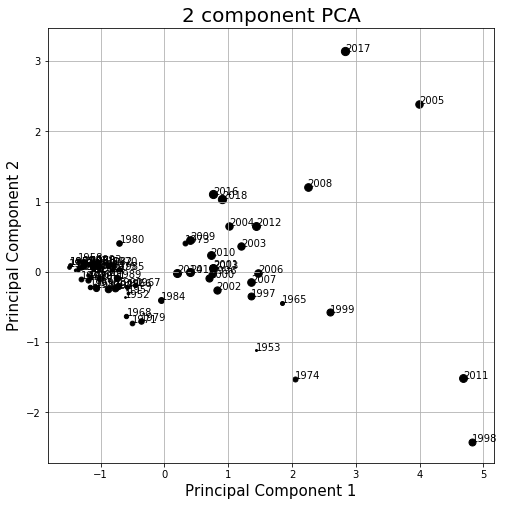

In [365]:
import matplotlib.pyplot as plt

# Visualize 2D PCA Projection
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

firstYear = 1950

for i, row in enumerate(principalComponents):
    ax.scatter(row[0], row[1], c = 'k', s = (i+1))
    ax.annotate(str(firstYear+i), (row[0], row[1]))
ax.grid()

In [378]:
from sklearn.decomposition import NMF

# NMF Projection to 2D
eventLosses = yearEventLosses[:,0:5:2]

nmf = NMF(n_components=2, solver="mu")
nmfProjection = nmf.fit_transform(eventLosses)

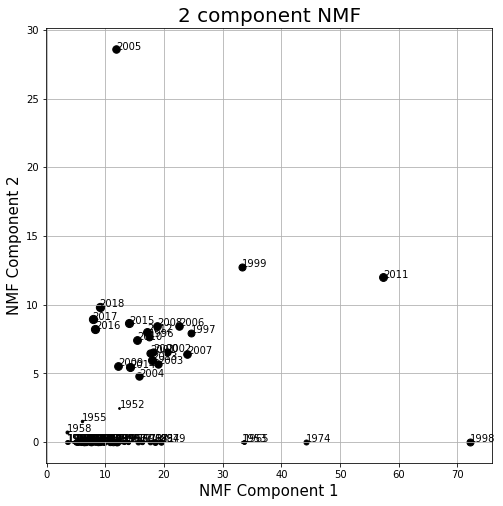

In [380]:
# Visualize 2D NMF Projection
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('NMF Component 1', fontsize = 15)
ax.set_ylabel('NMF Component 2', fontsize = 15)
ax.set_title('2 component NMF', fontsize = 20)

firstYear = 1950

for i, row in enumerate(nmfProjection):
    ax.scatter(row[0], row[1], c = 'k', s = (i+1))
    ax.annotate(str(firstYear+i), (row[0], row[1]))
ax.grid()

In [494]:
import us

# Reorganize event loss information
# Row: state/region; Column: Event loss type
# Clustering data according to state/region

# Determine all the states/regions
regions = []
for year in stormEvent:
    regions = set().union(regions,list(stormEvent[year]))

# Separate out states/territories
states = []
for region in regions:
    if us.states.lookup(region):
        states.append(region)

regions = regions.difference(states)
regions = list(regions)

# Determine the number of states/regions
numberStates = len(states)
numberRegions = len(regions)

# Select storm event loss types
selectedLossTypes = ['DirectInjuries', 'DirectDeaths', 'PropertyDamage']
numberSelectedLossTypes = len(selectedLossTypes)

stateEventLosses = np.zeros((numberStates, len(stormEvent), numberSelectedLossTypes))
for i, year in enumerate(stormEvent):
    for state in stormEvent[year]:
        if us.states.lookup(state):
            j = states.index(state)
            for event in stormEvent[year][state]:
                for lossType in stormEvent[year][state][event]:
                    if lossType in selectedLossTypes:
                        k = selectedLossTypes.index(lossType)
                        stateEventLosses[j,i,k] += sum(stormEvent[year][state][event][lossType])

# Adjusting dollar amounts for inflation
for i, year in enumerate(stormEvent):
    for j, _ in enumerate(states):
        k = selectedLossTypes.index('PropertyDamage')
        stateEventLosses[j,i,k] = cpi.inflate(stateEventLosses[j,i,k], year)

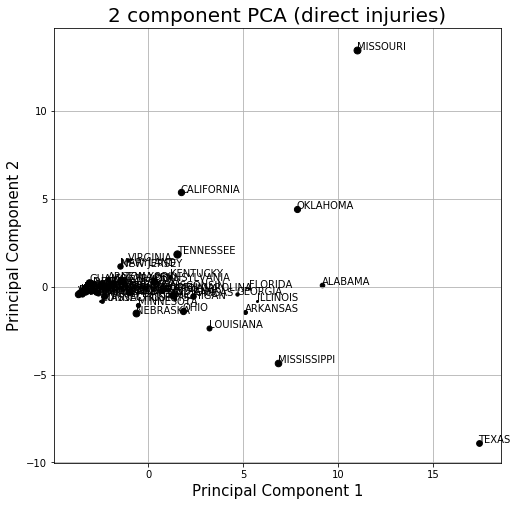

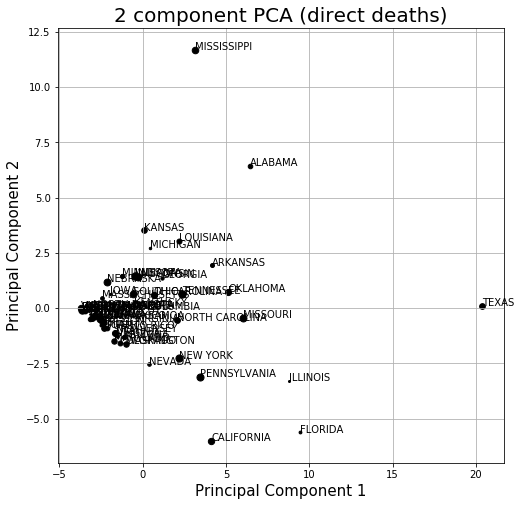

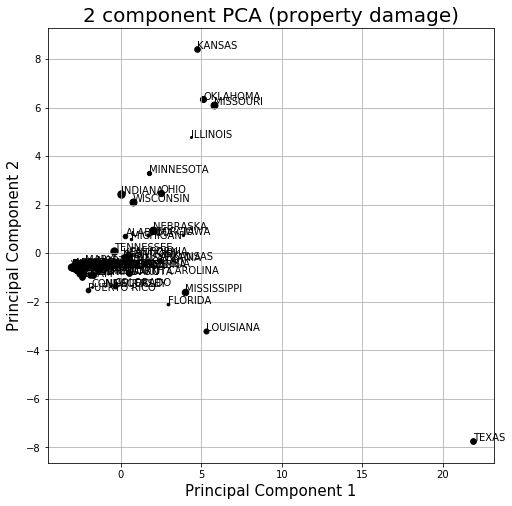

In [528]:
# PCA analysis for each of the selected loss types
for k, lossType in enumerate(selectedLossTypes):
    # Standardize the Data
    eventLosses = stateEventLosses[:,:,k]
    eventLosses = StandardScaler().fit_transform(eventLosses)
    
    # PCA Projection to 2D
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(eventLosses)

    # Visualize 2D PCA Projection
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    if lossType == 'DirectInjuries':
        titleInformation = 'direct injuries'
    elif lossType == 'DirectDeaths':
        titleInformation = 'direct deaths'
    elif lossType == 'PropertyDamage':
        titleInformation = 'property damage'
    ax.set_title('2 component PCA (%s)' % titleInformation, fontsize = 20)

    for i, row in enumerate(principalComponents):
        ax.scatter(row[0], row[1], c = 'k', s = 5)
        ax.annotate(states[i], (row[0], row[1]))
    ax.grid()

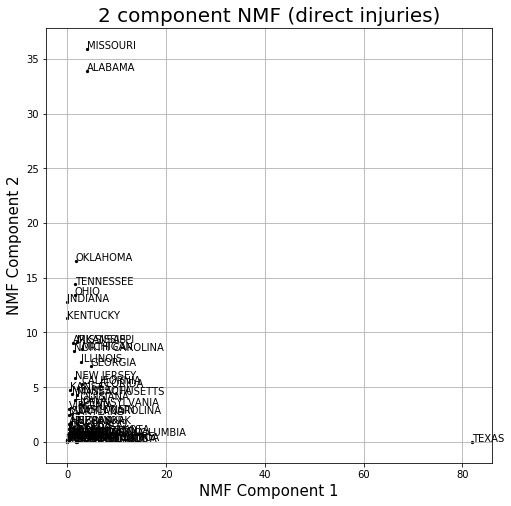

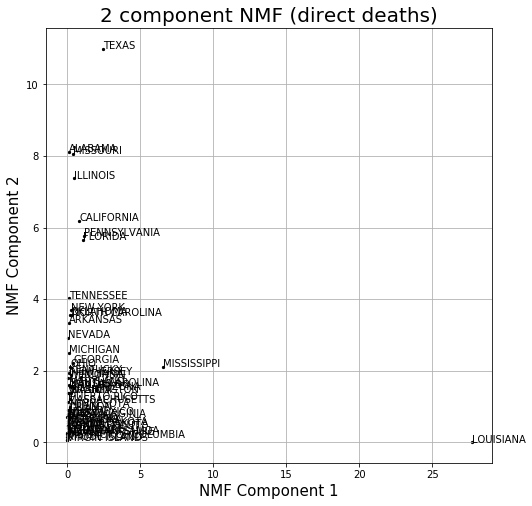

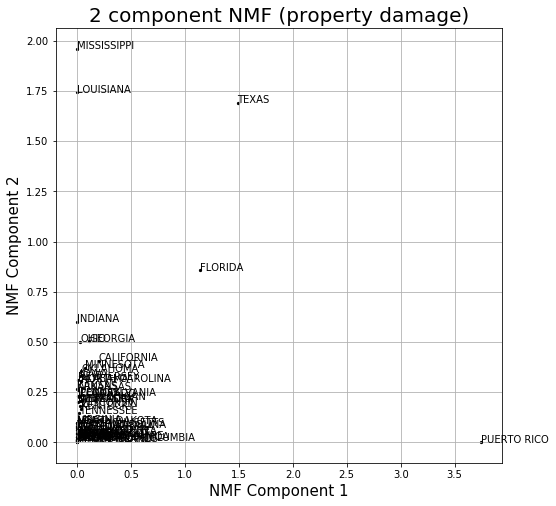

In [533]:
# NMF analysis for each of the selected loss types
for k, lossType in enumerate(selectedLossTypes):
    # NMF Projection to 2D
    eventLosses = stateEventLosses[:,:,k]

    nmf = NMF(n_components=2, solver="mu")
    nmfProjection = nmf.fit_transform(eventLosses)
    
    # Visualize 2D NMF Projection
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1)
    ax.set_xlabel('NMF Component 1', fontsize = 15)
    ax.set_ylabel('NMF Component 2', fontsize = 15)
    if lossType == 'DirectInjuries':
        titleInformation = 'direct injuries'
    elif lossType == 'DirectDeaths':
        titleInformation = 'direct deaths'
    elif lossType == 'PropertyDamage':
        titleInformation = 'property damage'
    ax.set_title('2 component NMF (%s)' % titleInformation, fontsize = 20)
    
    for i, row in enumerate(nmfProjection):
        ax.scatter(row[0], row[1], c = 'k', s = 5)
        ax.annotate(states[i], (row[0], row[1]))
    ax.grid()

In [456]:
# # Determine the number of storm event types
# eventTypes = []
# for year in stormEvent:
#     for state in stormEvent[year]:
#         eventTypes = set().union(eventTypes,list(stormEvent[year][state]))
# eventTypes = list(eventTypes)
# numberEventTypes = len(eventTypes)

# Injuries, deaths, and damage costs since 1950

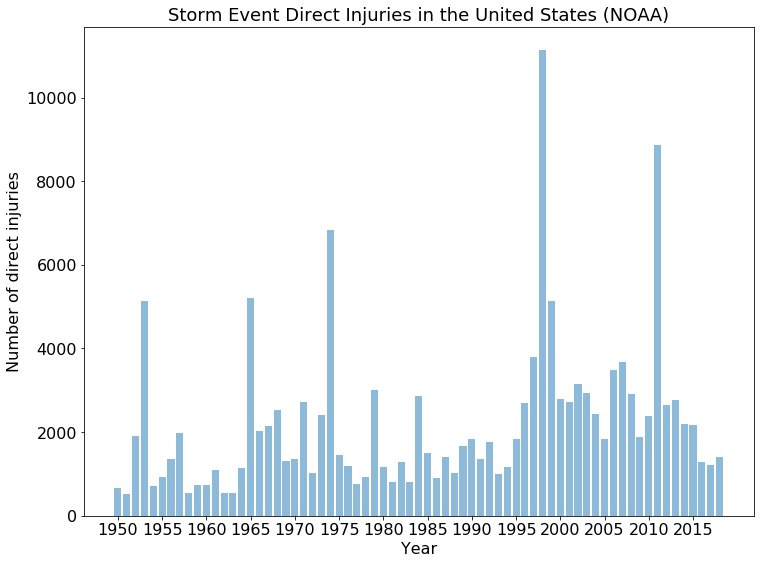

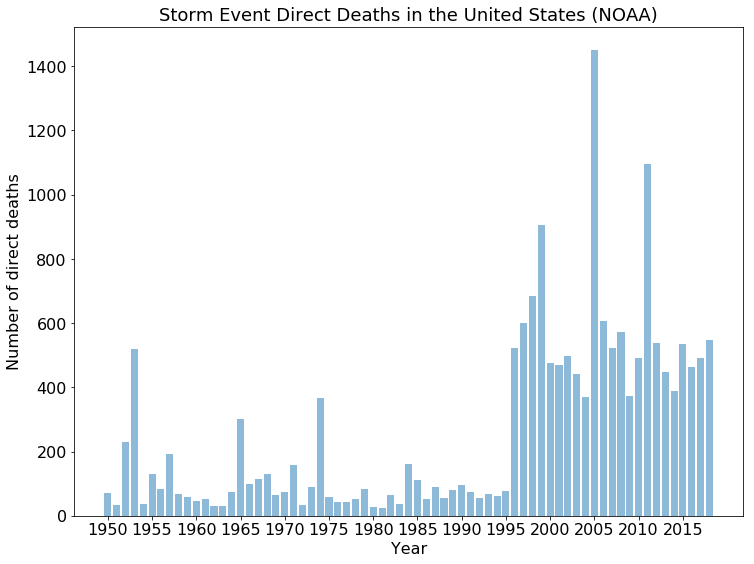

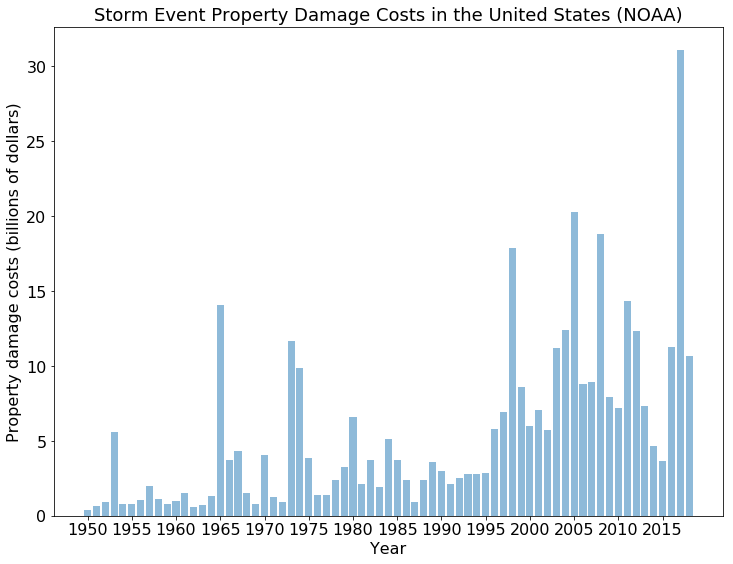

In [699]:
for lossType in selectedLossTypes:
    k = LossTypes.index(lossType)
    b_ctr = np.arange(len(stormEvent))
    b_ctr2 = np.arange(0,len(stormEvent),5)
    b_label = np.arange(firstYear,firstYear+len(stormEvent),5)
    
    plt.figure().set_size_inches(12, 9)
    plt.bar(b_ctr, yearEventLosses[:,k], align='center', alpha=0.5)
    
    plt.xticks(b_ctr2, b_label, fontsize=16)
    plt.tick_params(labelsize=16)
    
    plt.xlabel('Year', fontsize=16)
    if lossType == 'DirectInjuries':
        yLabelInformation = 'Number of direct injuries'
        titleInformation = 'Direct Injuries'
        saveInformation = 'direct_injuries'
    elif lossType == 'IndirectInjuries':
        yLabelInformation = 'Number of indirect injuries'
        titleInformation = 'Indirect Injuries'
        saveInformation = 'indirect_injuries'
    elif lossType == 'DirectDeaths':
        yLabelInformation = 'Number of direct deaths'
        titleInformation = 'Direct Deaths'
        saveInformation = 'direct_deaths'
    elif lossType == 'IndirectDeaths':
        yLabelInformation = 'Number of indirect deaths'
        titleInformation = 'Indirect Deaths'
        saveInformation = 'indirect_deaths'
    elif lossType == 'PropertyDamage':
        yLabelInformation = 'Property damage costs (billions of dollars)'
        titleInformation = 'Property Damage Costs'
        saveInformation = 'property_damage_costs'
    elif lossType == 'CropDamage':
        yLabelInformation = 'Crop damage costs (billions of dollars)'
        titleInformation = 'Crop Damage Costs'
        saveInformation = 'crop_damage_costs'
    plt.ylabel(yLabelInformation, fontsize=16)
    plt.title('Storm Event %s in the United States (NOAA)' % titleInformation, fontsize=18)
    plt.savefig(saveLocation + 'storm_event_connected_%s.jpeg' % saveInformation, dpi=600, transparent=True)

# Trends in injuries, deaths, and damage costs since 1950 in the United States

In [696]:
from sklearn.linear_model import LinearRegression

years = np.arange(firstYear,firstYear+len(stormEvent)).reshape((-1, 1))
eventLosses = yearEventLosses[:,0:5:2]

lRmodel = {}
for j, lossType in enumerate(selectedLossTypes):
    lRmodel[lossType] = LinearRegression().fit(years, eventLosses[:,j])
    if lossType == 'DirectInjuries':
        titleInformation = 'Direct Injury'
    elif lossType == 'DirectDeaths':
        titleInformation = 'Direct Death'
    elif lossType == 'PropertyDamage':
        titleInformation = 'Property Damage'
    print('Linear Regression (%s)' % titleInformation)
    print('slope:', '%.5f' % lRmodel[lossType].coef_[0])
    print('coefficient of determination:', '%.5f' % lRmodel[lossType].score(years, eventLosses[:,j]))
    print('')

Linear Regression (Direct Injury)
slope: 26.41922
coefficient of determination: 0.08208

Linear Regression (Direct Death)
slope: 8.73113
coefficient of determination: 0.38416

Linear Regression (Property Damage)
slope: 0.17150
coefficient of determination: 0.36602



In [689]:
linearRegressionModels = {}
for i, state in enumerate(states):
    linearRegressionModels[state] = {}
    for j, lossType in enumerate(selectedLossTypes):
        linearRegressionModels[state][lossType] = \
            LinearRegression().fit(years, stateEventLosses[i,:,j])

In [704]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

stateCodes = us.states.mapping('name','abbr')
meas = {}
for j, lossType in enumerate(selectedLossTypes):
    if lossType == 'DirectInjuries':
        titleInformation = 'Direct Injury'
    elif lossType == 'DirectDeaths':
        titleInformation = 'Direct Death'
    elif lossType == 'PropertyDamage':
        titleInformation = 'Property Damage'
    states2 = []
    meas['slopes'] = []
    meas['coefDet'] = []
    for i, state in enumerate(states):
        if not us.states.lookup(state).is_territory and not state == 'DISTRICT OF COLUMBIA':
            states2.append(stateCodes[state.title()])
            meas['slopes'].append(linearRegressionModels[state][lossType].coef_[0])
            meas['coefDet'].append(linearRegressionModels[state][lossType].score(years, stateEventLosses[i,:,j]))

    # Generate regression slope and coefficient of determination
    # heat maps of the United States
    for m in meas:
        if m == 'slopes':
            colorbar_title = 'slope'
            titleInformation2 = 'slope from linear regression'
        elif m == 'coefDet':
            colorbar_title = "R<sup>2</sup>"
            titleInformation2 = 'R<sup>2</sup> from linear regression'
        fig = go.Figure(data=go.Choropleth(
                        locations=states2, # Spatial coordinates
                        z=meas[m], # Data to be color-coded
                        locationmode = 'USA-states',
                        colorscale = 'Reds',
                        colorbar_title = colorbar_title,
                    ))

        fig.update_layout(
            title_text = '1950-2018 Storm Event %s Trends (%s)' % (titleInformation, titleInformation2),
            geo_scope='usa', # limite map scope to USA
        )
        fig.show()